In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from uproot_methods import TLorentzVectorArray
import coffea.processor as processor
import numpy as np
import numba as nb
import awkward as ak

In [2]:
# This is a helper function which adds muon (0) and electron (1) identifiers to a stacked lepton JaggedArray.
def make_labeled_p4(x, indices, itype):
    p4 = TLorentzVectorArray.from_ptetaphim(x.pt, x.eta, x.phi, x.mass)
    return ak.JaggedArray.zip(p4=p4,
                              ptype=itype*x.pt.ones_like().astype(np.int),
                              flavor=indices,
                              charge=x.charge)

# This generates a stacked lepton JaggedArray, allowing combination of both muons and electrons for computations across flavor.
def stack_leptons(muons, electrons):
    # Construct new lepton indices within every event array.
    muons_indices = ak.JaggedArray.fromoffsets(muons.pt.offsets, 
                                             np.arange(0, muons.pt.content.size)) - muons.pt.offsets[:-1]
    electrons_indices = ak.JaggedArray.fromoffsets(electrons.pt.offsets, 
                                             np.arange(0, electrons.pt.content.size)) - electrons.pt.offsets[:-1]
    # Assign 0/1 value depending on whether lepton is muon/electron.
    muons_p4 = make_labeled_p4(muons, muons_indices, 0)
    electrons_p4 = make_labeled_p4(electrons, electrons_indices, 1)
    # Concatenate leptons.
    stacked_p4 = ak.concatenate((muons_p4, electrons_p4), axis=1)
    
    return stacked_p4



In [3]:
# This program plots the transverse mass of MET and a third lepton, where the third lepton is associated with a lepton pair
# that has the same flavor, opposite charge, and closest mass to 91.2.

import math

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "MET and Third Lepton")
        muon_axis = hist.Bin("massT", "Transverse Mass", 50, 15, 250)
        
        self._accumulator = processor.dict_accumulator({
            'massT': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]

        muons = events.Muon
        electrons = events.Electron
        MET = events.MET
        
        # A few reasonable muon and electron selection cuts
        muons = muons[(muons.pt > 10) & (np.abs(muons.eta) < 2.4)]
        electrons = electrons[(electrons.pt > 10) & (np.abs(electrons.eta) < 2.5)]

        leptons = stack_leptons(muons, electrons)
        
        # Filter out events with less than 3 leptons.
        MET = MET[leptons.counts >= 3]
        trileptons = leptons[leptons.counts >= 3]
        
        # Generate the indices of every pair; indices because we'll be removing these elements later.
        lepton_pairs = trileptons.argchoose(2)
        
        # Select pairs that are SFOS.
        SFOS_pairs = lepton_pairs[(trileptons[lepton_pairs.i0].flavor == trileptons[lepton_pairs.i1].flavor) & (trileptons[lepton_pairs.i0].charge != trileptons[lepton_pairs.i1].charge)]
        
        # Find the pair with mass closest to Z.
        closest_pairs = SFOS_pairs[np.abs((trileptons[SFOS_pairs.i0].p4 + trileptons[SFOS_pairs.i1].p4).mass - 91.2).argmin()]
        
        # Remove elements of these pairs from leptons by negating the indices.
        is_in_pair_mask = trileptons[~closest_pairs.i0 | ~closest_pairs.i1]
        
        # Find the highest-pt lepton out of the ones that remain.
        leading_lepton = trileptons[trileptons.p4.pt.argmax()]
        
        # Can't cross MET with leading_lepton, but we need both phi and pt. So we build a crossable table.
        MET_tab = ak.JaggedArray.fromcounts(np.ones_like(MET.pt, dtype=np.int), ak.Table({'phi': MET.phi, 'pt': MET.pt}))
        met_plus_lep = MET_tab.cross(leading_lepton)
        
        # Do some math to get what we want.
        dphi_met_lep = (met_plus_lep.i0.phi - met_plus_lep.i1.p4.phi + math.pi) % (2*math.pi) - math.pi
        mt_lep = np.sqrt(2.0*met_plus_lep.i0.pt*met_plus_lep.i1.p4.pt*(1.0-np.cos(dphi_met_lep)))
        
        output['massT'].fill(dataset=dataset, massT=mt_lep.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

from dask.distributed import Client
from coffea_casa import CoffeaCasaCluster

client = Client("tls://localhost:8786")

output = processor.run_uproot_job(fileset=fileset, 
                       treename="Events", 
                       processor_instance=Processor(),
                       executor=processor.dask_executor,
                       executor_args={'client': client, 'nano': True},
                       chunksize=250000)

[##                                      ] | 6% Completed | 32.4s9s

distributed.comm.tcp - WARNING - Closing dangling stream in <TLS  local=tls://127.0.0.1:49042 remote=tls://localhost:8786>


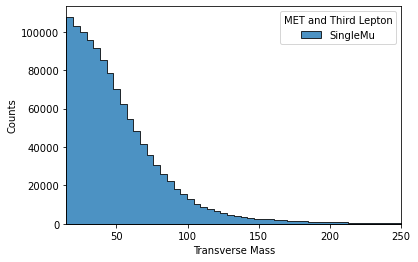

In [5]:
hist.plot1d(output['massT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})
#ax.set_yscale('log')
#ax.set_ylim(0.1, 2e5)

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)